In [1]:
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM, LSTM, SimpleRNN, GRU, Bidirectional
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout

from tensorflow.keras import regularizers

from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [2]:
import glob
import pandas as pd
import math
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

In [3]:
pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 4.7MB/s 
     |████████████████████████████████| 6.8MB 7.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
all_filenames = [i for i in glob.glob('/content/drive/My Drive/TrainingData/*.{}'.format('csv'))]

In [66]:
df_x, df_x_time, df_y, df_y_time = [], [], [], []
for f in all_filenames:
    if f.endswith('x.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_x.append(df)
    if f.endswith('x_time.csv'):
      df = pd.read_csv(f, header=None)
      df_x_time.append(df)
    if f.endswith('y.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_y.append(df)
    if f.endswith('y_time.csv'):
      df = pd.read_csv(f, header=None)
      df_y_time.append(df)
    
x = pd.concat(df_x, ignore_index=True)
x.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'subject', 'subject_ID']
x_time = pd.concat(df_x_time, ignore_index=True)
x_time.columns = ['x_time']
y = pd.concat(df_y, ignore_index=True)
y.columns = ['y', 'subject', 'subject_ID']
y_time = pd.concat(df_y_time, ignore_index=True)
y_time.columns = ['y_time']
x['time'] = x_time['x_time']
y['time'] = y_time['y_time']
y['time'] = [round(x+0.005,3) for x in y['time']]

In [ ]:
x.head(20)

In [ ]:
y.head(20)

In [68]:
x.drop(x[x['time'] == 0].index, inplace = True)

In [69]:
x.drop(x[x['time'] == 0.025].index, inplace = True)

In [70]:
full_df = pd.merge(x,y, on=['time','subject', 'subject_ID'], how='left')

In [10]:
full_df.head(20)

,x1,x2,x3,x4,x5,x6,subject,subject_ID,time,y
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,001,01,0.000,NaN
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,001,01,0.025,0.0
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,001,01,0.050,NaN
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,001,01,0.075,NaN
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,001,01,0.100,NaN
5,4.226515,8.273807,2.851742,0.012534,0.000445,-0.016830,001,01,0.125,0.0
6,4.532063,8.398341,2.856682,0.014484,0.028769,-0.011091,001,01,0.150,NaN
7,4.433669,8.294719,2.823521,0.016340,-0.029434,-0.008998,001,01,0.175,NaN
8,4.160676,8.260676,2.827568,0.011222,-0.016748,-0.006027,001,01,0.200,NaN
9,4.432763,8.272613,2.790050,-0.002715,0.023094,0.012222,001,01,0.225,0.0


In [11]:
# full_df['y'] = full_df['y'].fillna(method='backfill')
# full_df.dropna(inplace=True)

In [14]:
full_df.shape

(1367084, 10)

In [71]:
from numpy import array
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [72]:
in_seq1 = full_df['x1'].to_numpy().reshape((len(full_df['x1']), 1))
in_seq2 = full_df['x2'].to_numpy().reshape((len(full_df['x2']), 1))
in_seq3 = full_df['x3'].to_numpy().reshape((len(full_df['x3']), 1))
in_seq4 = full_df['x4'].to_numpy().reshape((len(full_df['x4']), 1))
in_seq5 = full_df['x5'].to_numpy().reshape((len(full_df['x5']), 1))
in_seq6 = full_df['x6'].to_numpy().reshape((len(full_df['x6']), 1))

In [73]:
out_seq = full_df['y'].to_numpy().reshape((len(full_df['y']), 1))

In [74]:
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq))

In [75]:
X, y = split_sequences(dataset, 4)

In [76]:
ind = np.argwhere(np.isnan(y)).flatten()

In [77]:
allrows = np.array(range(len(X)))
X_n = X[np.setdiff1d(allrows,ind)]

In [78]:
y = y[~np.isnan(y)]

In [79]:
X_n = X_n.reshape(-1,24)

In [80]:
X_n.shape

(302228, 24)

In [27]:
y = y.reshape(-1,1)

In [28]:
y.shape

(1367081, 1)

In [29]:
unique, counts = np.unique(y, return_counts=True)

In [30]:
print(unique)
print(counts)

[0. 1. 2. 3.]
[1016328   91483   50966  208304]


In [98]:
# RNN Model with LSTM
model = Sequential()
# model.add(Embedding(130, 128, input_length=num_steps))
# model.add(Dropout(0.7))
model.add(LSTM(128, input_shape=(1,24), recurrent_activation='swish', return_sequences=True))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, recurrent_activation='swish', return_sequences=True)))
model.add(BatchNormalization())
model.add(LSTM(128, recurrent_activation='swish'))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy', f1_m], sample_weight_mode="temporal")
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 128)            78336     
_________________________________________________________________
batch_normalization_18 (Batc (None, 1, 128)            512       
_________________________________________________________________
bidirectional_6 (Bidirection (None, 1, 128)            98816     
_________________________________________________________________
batch_normalization_19 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               131584    
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                

In [83]:
model.output_shape

(None, 4)

In [84]:
model.input_shape

(None, 1, 24)

In [45]:
# CNN model
model_CNN1 = Sequential()

#Adding the input layer and first hidden layer
model_CNN1.add(Dense(256, activation= 'swish', input_shape=(1,24)))
# model_CNN1.add(Dropout(0.25))
#Adding second hidden layer
model_CNN1.add(Dense(512, activation= 'swish'))
model_CNN1.add(BatchNormalization())
# model_CNN1.add(Dropout(0.25))
model_CNN1.add(Dense(256, activation= 'swish'))
model_CNN1.add(BatchNormalization())
model_CNN1.add(Dense(128, activation= 'swish'))
model_CNN1.add(BatchNormalization())
model_CNN1.add(Dense(64, activation= 'swish'))
model_CNN1.add(BatchNormalization())
#Adding the Output Layer
model_CNN1.add(Dense(4, activation='softmax')) 
#Compiling
model_CNN1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m, 'categorical_accuracy'])
model_CNN1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 1, 256)            6400      
_________________________________________________________________
dense_27 (Dense)             (None, 1, 512)            131584    
_________________________________________________________________
batch_normalization_18 (Batc (None, 1, 512)            2048      
_________________________________________________________________
dense_28 (Dense)             (None, 1, 256)            131328    
_________________________________________________________________
batch_normalization_19 (Batc (None, 1, 256)            1024      
_________________________________________________________________
dense_29 (Dense)             (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_20 (Batc (None, 1, 128)           

In [79]:
# CNN model
model_CNN = Sequential()

#Adding the input layer and first hidden layer
model_CNN.add(Dense(256, activation= 'swish', input_shape=(1,24)))
#Adding second hidden layer
model_CNN.add(Dense(512, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(512, activation= 'swish'))
model_CNN1.add(Dropout(0.25))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(256, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(128, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(64, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(32, activation= 'swish'))
model_CNN.add(BatchNormalization())
#Adding the Output Layer
model_CNN.add(Dense(4, activation='softmax')) 
#Compiling
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', f1_m], sample_weight_mode="temporal")
model_CNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1, 256)            6400      
_________________________________________________________________
dense_41 (Dense)             (None, 1, 512)            131584    
_________________________________________________________________
batch_normalization_28 (Batc (None, 1, 512)            2048      
_________________________________________________________________
dense_42 (Dense)             (None, 1, 512)            262656    
_________________________________________________________________
batch_normalization_29 (Batc (None, 1, 512)            2048      
_________________________________________________________________
dense_43 (Dense)             (None, 1, 256)            131328    
_________________________________________________________________
batch_normalization_30 (Batc (None, 1, 256)           

In [80]:
model_CNN.input_shape

(None, 1, 24)

In [81]:
model_CNN.output_shape

(None, 1, 4)

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.25, random_state=177)

In [86]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,24))
X_test = scaler.transform(X_test.reshape(-1,24))

In [87]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3.]
[169375   9196  10951  37149]


In [88]:
# Over Sampling using kmeansSMOTE
oversample = KMeansSMOTE(sampling_strategy='auto', cluster_balance_threshold=0.048, k_neighbors=3)

In [89]:
X_train = X_train.reshape(-1,24)

In [90]:
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [51]:
# Downsampling -- optional
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

In [52]:
unique, counts = np.unique(y_rus, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3.]
[38057 38057 38057 38057]


In [91]:
# Ading class weight parameter in CNN models
class_weights = np.zeros((len(y_train), 4))
class_weights[:, 0] += 1
class_weights[:, 1] += 15
class_weights[:, 2] += 20
class_weights[:, 3] += 5

In [88]:
unique, counts = np.unique(y_train, return_counts=True)

In [89]:
print(unique)
print(counts)

[0. 1. 2. 3.]
[169375 169376 169376 169380]


In [ ]:
X_test.shape

(90669, 24)

In [93]:
X_train = X_train.reshape(-1,1,24)
X_test = X_test.reshape(-1,1,24)

In [94]:
model.output_shape

(None, 4)

In [95]:
# Reshape according to model output size
y_train = to_categorical(y_train).reshape(-1,4)
y_test = to_categorical(y_test).reshape(-1,4)

In [60]:
y_train.shape

(1025310, 4)

In [58]:
# Saving best model each time
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/My Drive/RNNbi411{epoch:08d}.h5', save_best_only=True) 

In [ ]:
RNN_swish_down_prev = model.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=240)

Epoch 1/40
2823/2823 [==============================] - 66s 23ms/step - loss: 0.8542 - categorical_accuracy: 0.6502 - f1_m: 0.5871 - val_loss: 1.1548 - val_categorical_accuracy: 0.5512 - val_f1_m: 0.5422
Epoch 2/40
2823/2823 [==============================] - 67s 24ms/step - loss: 0.5459 - categorical_accuracy: 0.8113 - f1_m: 0.8077 - val_loss: 1.1118 - val_categorical_accuracy: 0.5807 - val_f1_m: 0.5743
Epoch 3/40
2823/2823 [==============================] - 64s 23ms/step - loss: 0.4836 - categorical_accuracy: 0.8344 - f1_m: 0.8326 - val_loss: 1.0603 - val_categorical_accuracy: 0.6073 - val_f1_m: 0.5994
Epoch 4/40
2823/2823 [==============================] - 64s 23ms/step - loss: 0.4414 - categorical_accuracy: 0.8499 - f1_m: 0.8484 - val_loss: 1.0177 - val_categorical_accuracy: 0.6272 - val_f1_m: 0.6214
Epoch 5/40
2823/2823 [==============================] - 65s 23ms/step - loss: 0.4138 - categorical_accuracy: 0.8599 - f1_m: 0.8586 - val_loss: 1.0195 - val_categorical_accuracy: 0.6351

In [63]:
RNN_swish_down = model.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=240)

Epoch 1/40
4273/4273 [==============================] - 104s 24ms/step - loss: 0.8329 - categorical_accuracy: 0.7400 - f1_m: 0.7300 - val_loss: 0.8095 - val_categorical_accuracy: 0.7411 - val_f1_m: 0.7406
Epoch 2/40
4273/4273 [==============================] - 103s 24ms/step - loss: 0.7880 - categorical_accuracy: 0.7444 - f1_m: 0.7438 - val_loss: 0.7769 - val_categorical_accuracy: 0.7429 - val_f1_m: 0.7420
Epoch 3/40
4273/4273 [==============================] - 102s 24ms/step - loss: 0.7508 - categorical_accuracy: 0.7477 - f1_m: 0.7467 - val_loss: 0.7411 - val_categorical_accuracy: 0.7474 - val_f1_m: 0.7461
Epoch 4/40
4273/4273 [==============================] - 101s 24ms/step - loss: 0.7289 - categorical_accuracy: 0.7508 - f1_m: 0.7497 - val_loss: 0.7227 - val_categorical_accuracy: 0.7511 - val_f1_m: 0.7495
Epoch 5/40
4273/4273 [==============================] - 102s 24ms/step - loss: 0.7152 - categorical_accuracy: 0.7536 - f1_m: 0.7523 - val_loss: 0.7107 - val_categorical_accuracy: 0

In [93]:
CNN_swish = model_CNN.fit(X_train, y_train, epochs = 20, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=240, sample_weight=class_weights)

Epoch 1/20
2823/2823 [==============================] - 88s 31ms/step - loss: 6.0575 - categorical_accuracy: 0.7906 - f1_m: 0.7845 - val_loss: 1.0125 - val_categorical_accuracy: 0.6174 - val_f1_m: 0.6021
Epoch 2/20
2823/2823 [==============================] - 87s 31ms/step - loss: 4.4855 - categorical_accuracy: 0.8467 - f1_m: 0.8452 - val_loss: 0.9602 - val_categorical_accuracy: 0.6572 - val_f1_m: 0.6463
Epoch 3/20
2823/2823 [==============================] - 88s 31ms/step - loss: 3.8825 - categorical_accuracy: 0.8671 - f1_m: 0.8665 - val_loss: 0.9366 - val_categorical_accuracy: 0.6693 - val_f1_m: 0.6602
Epoch 4/20
2823/2823 [==============================] - 88s 31ms/step - loss: 3.5129 - categorical_accuracy: 0.8803 - f1_m: 0.8797 - val_loss: 0.9267 - val_categorical_accuracy: 0.6773 - val_f1_m: 0.6690
Epoch 5/20
2823/2823 [==============================] - 90s 32ms/step - loss: 3.2541 - categorical_accuracy: 0.8891 - f1_m: 0.8888 - val_loss: 0.8979 - val_categorical_accuracy: 0.6947

In [39]:
CNN_Swish_f1 = model_CNN1.fit(X_train, y_train, epochs = 20, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=240)

Epoch 1/20
2823/2823 [==============================] - 62s 22ms/step - loss: 0.7893 - f1_m: 0.6761 - categorical_accuracy: 0.6959 - val_loss: 1.1743 - val_f1_m: 0.4904 - val_categorical_accuracy: 0.5016
Epoch 2/20
2823/2823 [==============================] - 67s 24ms/step - loss: 0.6184 - f1_m: 0.7641 - categorical_accuracy: 0.7715 - val_loss: 1.1424 - val_f1_m: 0.5276 - val_categorical_accuracy: 0.5426
Epoch 3/20
2823/2823 [==============================] - 66s 23ms/step - loss: 0.5365 - f1_m: 0.8012 - categorical_accuracy: 0.8053 - val_loss: 1.1172 - val_f1_m: 0.5538 - val_categorical_accuracy: 0.5675
Epoch 4/20
2823/2823 [==============================] - 66s 23ms/step - loss: 0.4905 - f1_m: 0.8210 - categorical_accuracy: 0.8237 - val_loss: 1.0775 - val_f1_m: 0.5765 - val_categorical_accuracy: 0.5886
Epoch 5/20
2823/2823 [==============================] - 64s 23ms/step - loss: 0.4608 - f1_m: 0.8326 - categorical_accuracy: 0.8352 - val_loss: 1.0577 - val_f1_m: 0.5936 - val_categoric

In [ ]:
RNN_history = model.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=240)


Epoch 1/40
2635/2635 [==============================] - 44s 17ms/step - loss: 0.5451 - categorical_accuracy: 0.8111 - f1_m: 0.8074 - precision_m: 0.8285 - recall_m: 0.7875 - val_loss: 1.0722 - val_categorical_accuracy: 0.5837 - val_f1_m: 0.5702 - val_precision_m: 0.5930 - val_recall_m: 0.5492
Epoch 2/40
2635/2635 [==============================] - 44s 17ms/step - loss: 0.4748 - categorical_accuracy: 0.8343 - f1_m: 0.8326 - precision_m: 0.8481 - recall_m: 0.8177 - val_loss: 1.0630 - val_categorical_accuracy: 0.6031 - val_f1_m: 0.5908 - val_precision_m: 0.6113 - val_recall_m: 0.5717
Epoch 3/40
2635/2635 [==============================] - 44s 17ms/step - loss: 0.4424 - categorical_accuracy: 0.8449 - f1_m: 0.8433 - precision_m: 0.8569 - recall_m: 0.8303 - val_loss: 1.0292 - val_categorical_accuracy: 0.6252 - val_f1_m: 0.6166 - val_precision_m: 0.6333 - val_recall_m: 0.6009
Epoch 4/40
2635/2635 [==============================] - 44s 17ms/step - loss: 0.4205 - categorical_accuracy: 0.8520 - 

In [ ]:
# Training RNN model
CNN_history = model_CNN1.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=240)

Epoch 1/40
2635/2635 [==============================] - 55s 21ms/step - loss: 0.6474 - categorical_accuracy: 0.7681 - f1_m: 0.7591 - precision_m: 0.7977 - recall_m: 0.7249 - val_loss: 1.0764 - val_categorical_accuracy: 0.6070 - val_f1_m: 0.6025 - val_precision_m: 0.6234 - val_recall_m: 0.5830
Epoch 2/40
2635/2635 [==============================] - 55s 21ms/step - loss: 0.4859 - categorical_accuracy: 0.8318 - f1_m: 0.8296 - precision_m: 0.8486 - recall_m: 0.8115 - val_loss: 1.0185 - val_categorical_accuracy: 0.6311 - val_f1_m: 0.6258 - val_precision_m: 0.6435 - val_recall_m: 0.6092
Epoch 3/40
2635/2635 [==============================] - 57s 22ms/step - loss: 0.4350 - categorical_accuracy: 0.8499 - f1_m: 0.8485 - precision_m: 0.8627 - recall_m: 0.8348 - val_loss: 1.0167 - val_categorical_accuracy: 0.6418 - val_f1_m: 0.6382 - val_precision_m: 0.6521 - val_recall_m: 0.6249
Epoch 4/40
2635/2635 [==============================] - 55s 21ms/step - loss: 0.4069 - categorical_accuracy: 0.8596 - 

In [ ]:
model_CNN.output_shape

(None, 1, 4)

In [ ]:
X_k, y_k = oversample.fit_resample(X_n_scaled, y)

In [ ]:
y_k = to_categorical(y_k).reshape(-1,1,4)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
# Training RNN model
CNN1extra_history = model_CNN1.fit(X_train, y_train, epochs = 20, validation_data= (X_test, y_test), callbacks=[checkpoint])

In [ ]:
from keras.models import load_model
model = load_model('RNN_model.h5')

In [94]:
def split_test_sequences(sequences, n_steps):
  X = list()
  end_flag = True 
  for i in range(0,len(sequences),4):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences):
      end_flag = False
      seq_x = sequences[-4:, :]
      X.append(seq_x)
      break
    # gather input and output parts of the pattern
    if (end_flag):
      seq_x = sequences[i:end_ix, :]
      X.append(seq_x)
  return array(X)

In [ ]:
model_CNN.input_shape

(None, 1, 24)

In [95]:
test_filenames = [i for i in glob.glob('/content/drive/My Drive/TestData/*.{}'.format('csv'))]
df_x, df_x_time, df_y_time = [], [], []
for f in test_filenames:
  if '012' in f:
    if f.endswith('x.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_x.append(df)
    if f.endswith('x_time.csv'):
      df = pd.read_csv(f, header=None)
      df_x_time.append(df)
    if f.endswith('y_time.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_y_time.append(df)
    
test_x = pd.concat(df_x, ignore_index=True)
test_x.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'subject', 'subject_ID']
test_x_time = pd.concat(df_x_time, ignore_index=True)
test_x_time.columns = ['x_time']
test_y_time = pd.concat(df_y_time, ignore_index=True)
test_y_time.columns = ['time', 'subject', 'subject_ID']
test_x['time'] = test_x_time['x_time']
test_y_time['time'] = [round(x + 0.005,3) for x in test_y_time['time']]
final_test = pd.merge(test_x, test_y_time, on=['time', 'subject', 'subject_ID'], how='left')
in_seq1 = final_test['x1'].to_numpy().reshape((len(final_test['x1']), 1))
in_seq2 = final_test['x2'].to_numpy().reshape((len(final_test['x2']), 1))
in_seq3 = final_test['x3'].to_numpy().reshape((len(final_test['x3']), 1))
in_seq4 = final_test['x4'].to_numpy().reshape((len(final_test['x4']), 1))
in_seq5 = final_test['x5'].to_numpy().reshape((len(final_test['x5']), 1))
in_seq6 = final_test['x6'].to_numpy().reshape((len(final_test['x6']), 1))
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6))
test_x = split_test_sequences(dataset, 4)
test_x = test_x[:len(test_y_time),:]
scaler = StandardScaler()
test_x = scaler.fit_transform(test_x.reshape(-1,24))
test = test_x.reshape(-1,1,24)
y_pred = model_CNN.predict(test)
y_pred = np.argmax(y_pred.reshape(-1,4), axis=1)
np.savetxt("subject_012_01__y_prediction.csv", y_pred, delimiter=",")

In [100]:
test_y_time.head()

,time,subject,subject_ID
0,0.025,012,01
1,0.125,012,01
2,0.225,012,01
3,0.325,012,01
4,0.425,012,01


In [101]:
final_test.head()

,x1,x2,x3,x4,x5,x6,subject,subject_ID,time
0,-0.226662,9.070000,3.480012,0.002707,-0.008122,-0.005212,012,01,0.000
1,-0.251041,9.060000,3.498959,0.002710,-0.000135,-0.002046,012,01,0.025
2,-0.224829,9.055514,3.489657,0.004959,0.002819,-0.002819,012,01,0.050
3,-0.169111,9.090889,3.491777,0.003085,-0.001072,-0.001399,012,01,0.075
4,-0.230224,9.070000,3.470448,0.003333,-0.004154,-0.003624,012,01,0.100


In [ ]:
in_seq1 = final_test['x1'].to_numpy().reshape((len(final_test['x1']), 1))
in_seq2 = final_test['x2'].to_numpy().reshape((len(final_test['x2']), 1))
in_seq3 = final_test['x3'].to_numpy().reshape((len(final_test['x3']), 1))
in_seq4 = final_test['x4'].to_numpy().reshape((len(final_test['x4']), 1))
in_seq5 = final_test['x5'].to_numpy().reshape((len(final_test['x5']), 1))
in_seq6 = final_test['x6'].to_numpy().reshape((len(final_test['x6']), 1))

In [ ]:
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6))

In [ ]:
test_x = split_test_sequences(dataset, 4)

In [ ]:
test_x = test_x[:len(test_y_time),:]

In [ ]:
test_x.shape

(11330, 4, 6)

In [ ]:
scaler = StandardScaler()
test_x = scaler.fit_transform(test_x.reshape(-1,24))

In [ ]:
test = test_x.reshape(-1,1,24)
y_pred = model_CNN1.predict(test)
y_pred = np.argmax(y_pred.reshape(-1,4), axis=1)
np.savetxt("subject_011_01__y_prediction.csv", y_pred, delimiter=",")

In [ ]:
y_p = y_pred.reshape(-1,4)

In [ ]:
np.argmax(y_p, axis=1).shape

In [ ]:
test_x.head()

In [ ]:
test_y_time.head()

In [ ]:
test_y_time['time'] = [x + 0.005 for x in test_y_time['time']]

In [ ]:
test_x.head()

In [ ]:
test_y_time.head()

In [ ]:
final_test.fillna(method='ffill', inplace=True)

In [ ]:
final_test.shape

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

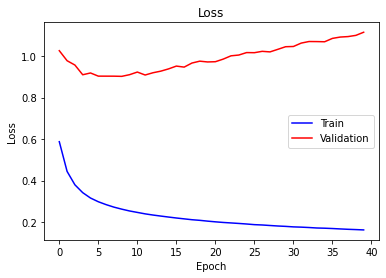

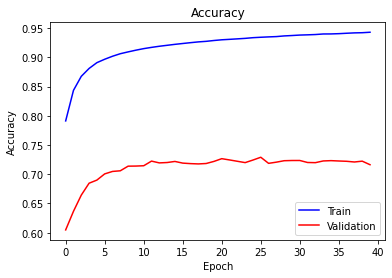

In [ ]:
plot_history(CNN_Swish_history)

In [ ]:
plt.plot(RNN_history.history['f1_m'], color='blue', label='train')
plt.plot(RNN_history.history['val_f1_m'], color='red', label='test')
plt.ylabel('F1 Scores')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

In [ ]:
from sklearn.metrics import classification_report
y_p = model.predict(X_test)
y_p = np.argmax(y_p.reshape(-1,4), axis=1)
y_test = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test, y_p))

In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)

In [ ]:
print(unique)
print(counts)

In [ ]:
y_pred.to_csv('subject_012_01__y_prediction.csv', header=None)

In [ ]:
!mkdir -p saved_model
model.save('saved_model/final_model')


In [ ]:
!ls saved_model

In [ ]:
model = tf.keras.models.load_model('saved_model/CNN_model')

# Check its architecture
model.summary()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = (y_pred > 0.5) 

In [ ]:
y_pred[1]